<a href="https://colab.research.google.com/github/poojamahajan0712/AI_ML_concepts/blob/main/Learning_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model compression technique
* given nowadays LLMs have large size , this comes handy in working with these models.<br>
There are different methods to do :-
1. Pruning - simply removing some of the layers and connections that do not have much importance
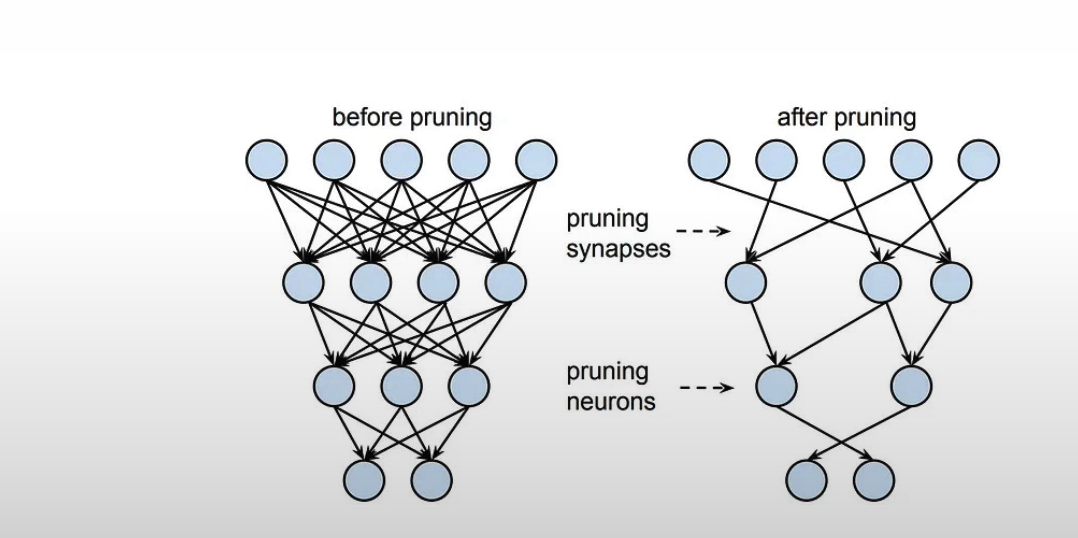

2. Knowledge Distillation:- Train a student model- target compressed model  using original model, challenge is to have enough compute to initially fit the original model
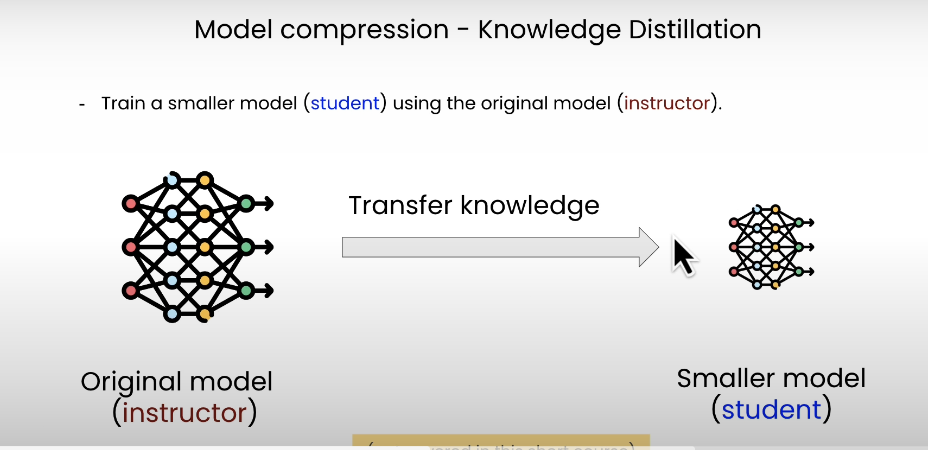

3. Quantization
* You can either quantise weights(W) ,sometimes  activations  also.
* Key idea is to store model parameters in lower precision.
* while converting to lower precision , we may have quantization error that may lead to performance degaradation


- Data Types
-- Int8 - range of 0-255
-- Unsigned Int8 - -128,127- first bit for sign

In [ ]:
import torch

Integers

In [ ]:
##8 bit
torch.iinfo(torch.uint8), torch.iinfo(torch.int8)

(iinfo(min=0, max=255, dtype=uint8), iinfo(min=-128, max=127, dtype=int8))

In [ ]:
torch.iinfo(torch.int64)

iinfo(min=-9.22337e+18, max=9.22337e+18, dtype=int64)

In [ ]:
torch.iinfo(torch.int32)

iinfo(min=-2.14748e+09, max=2.14748e+09, dtype=int32)

In [ ]:
## 16 bit
torch.iinfo(torch.int16),torch.iinfo(torch.uint16)

(iinfo(min=-32768, max=32767, dtype=int16),
 iinfo(min=0, max=65535, dtype=uint16))

Floating <br>
Three parts to float numbers  - sign bit, exponent(range) - impact the representable range of the number, fraction(precision) - im

* FP32 - 1 sign bit, 8 exponent, 23 fraction
* FP16 - 1 sign bit, 5 exponent, 10 fraction
* BF16 - 1 sign bit, 8 exponent, 7 fraction

bf16 has a bigger range than fp16 although precision is lesser compared to fp16

In [ ]:
val=1/6
tensor_fp64 = torch.tensor(val, dtype = torch.float64)
tensor_fp64

tensor(0.1667, dtype=torch.float64)

In [ ]:
tensor_fp32 = torch.tensor(val, dtype = torch.float32)
tensor_fp16 = torch.tensor(val, dtype = torch.float16)
tensor_bf16 = torch.tensor(val, dtype = torch.bfloat16)

print(f"fp64 tensor: {format(tensor_fp64.item(), '.60f')}")
print(f"fp32 tensor: {format(tensor_fp32.item(), '.60f')}")
print(f"fp16 tensor: {format(tensor_fp16.item(), '.60f')}")
print(f"bf16 tensor: {format(tensor_bf16.item(), '.60f')}")

fp64 tensor: 0.166666666666666657414808128123695496469736099243164062500000
fp32 tensor: 0.166666671633720397949218750000000000000000000000000000000000
fp16 tensor: 0.166625976562500000000000000000000000000000000000000000000000
bf16 tensor: 0.166992187500000000000000000000000000000000000000000000000000


floating point details - 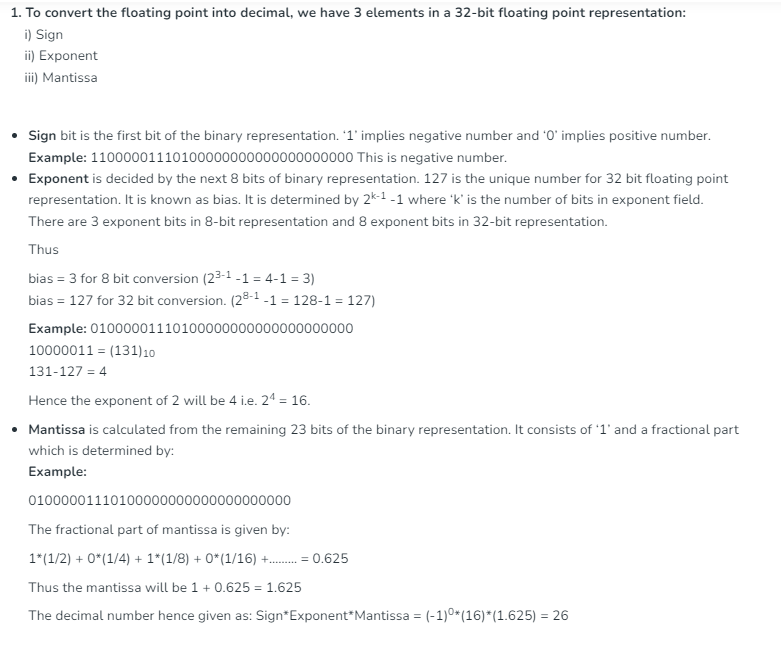

range of fp32 and bf16 is close however precision is quite different although it takes half of the size of fp32

In [16]:
torch.finfo(torch.float16)

finfo(resolution=0.001, min=-65504, max=65504, eps=0.000976562, smallest_normal=6.10352e-05, tiny=6.10352e-05, dtype=float16)

In [17]:
torch.finfo(torch.bfloat16)

finfo(resolution=0.01, min=-3.38953e+38, max=3.38953e+38, eps=0.0078125, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=bfloat16)

In [18]:
torch.finfo(torch.float32)

finfo(resolution=1e-06, min=-3.40282e+38, max=3.40282e+38, eps=1.19209e-07, smallest_normal=1.17549e-38, tiny=1.17549e-38, dtype=float32)

Downcasting

In [19]:
# random pytorch tensor: float32, size=1000
tensor_fp32 = torch.rand(1000, dtype = torch.float32)
# first 5 elements of the random tensor
tensor_fp32[:5]

tensor([0.8379, 0.5255, 0.3282, 0.8590, 0.6421])

In [22]:
# downcast the tensor to bfloat16 using the "to" method
tensor_fp32_to_bf16 = tensor_fp32.to(dtype = torch.bfloat16)
tensor_fp32_to_bf16[:5] ## precision changed

tensor([0.8398, 0.5273, 0.3281, 0.8594, 0.6406], dtype=torch.bfloat16)

In [24]:
# understand impact on multiplication

# tensor_fp32 x tensor_fp32
m_float32 = torch.dot(tensor_fp32, tensor_fp32)
m_float32

tensor(323.0186)

In [26]:
# tensor_fp32_to_bf16 x tensor_fp32_to_bf16
m_bfloat16 = torch.dot(tensor_fp32_to_bf16, tensor_fp32_to_bf16)
m_bfloat16 ## result is quite close but we do have loss of precision

tensor(324., dtype=torch.bfloat16)

Load Model
* Model Casting - using any of the three
-- model = model.to(DATATYPE)
-- model = model.half
-- model = model.bfloat16
----- with pytorch there is an issue if we downcast the transformer based model to float16 then cpu inferencing throws some unimplemented error, so to resolve this we can use bfloat16 instead of fp16.

## Using a multimodal model
- Load [Salesforce/blip-image-captioning-base](https://huggingface.co/Salesforce/blip-image-captioning-base) to perform image captioning.

#### To get the sample code :
- Click on the "Model Card" tab.
- On the right, click on the button "<> Use in Transformers", you'll see a popup with sample code for loading this model.


In [61]:
from IPython.display import display
import requests
from PIL import Image
from transformers import BlipForConditionalGeneration
from transformers import BlipProcessor

In [62]:
def print_param_dtype(model):
    for name, param in model.named_parameters():
        print(f"{name} is loaded in {param.dtype}")

def get_generation(model, processor, image, dtype):
    inputs = processor(image, return_tensors="pt").to(dtype)
    out = model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True)

In [63]:
model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name)


In [32]:
#inspect the default data types of the model

# print_param_dtype(model)

In [34]:
fp32_mem_footprint = model.get_memory_footprint()
print("Footprint of the fp32 model in bytes: ",
      fp32_mem_footprint)
print("Footprint of the fp32 model in MBs: ",
      fp32_mem_footprint/1e+6)

Footprint of the fp32 model in bytes:  989660400
Footprint of the fp32 model in MBs:  989.6604


In [55]:
## downcasting to bfloat16
model_bf16 = BlipForConditionalGeneration.from_pretrained(
                                               model_name,
                               torch_dtype=torch.bfloat16)

In [56]:
bf16_mem_footprint = model_bf16.get_memory_footprint()
# Get the relative difference
relative_diff = bf16_mem_footprint / fp32_mem_footprint
print("Footprint of the bf16 model in MBs: ", bf16_mem_footprint/1e+6)
print(f"Relative diff: {relative_diff}")

Footprint of the bf16 model in MBs:  494.832248
Relative diff: 0.5000020693967345


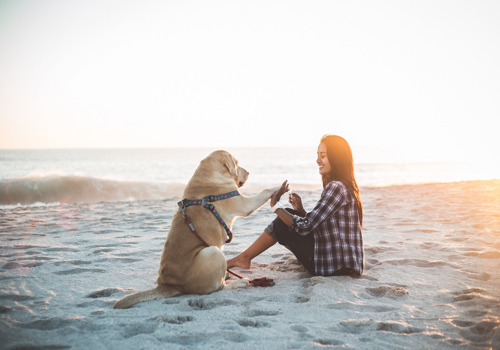

In [57]:
### testing a sample image for checking output on both fp32 and fp16 model
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
display(image.resize((500, 350)))

In [58]:
results_fp32 = get_generation(model,
                              processor,
                              image,
                              torch.float32)
print("fp32 Model Results:\n", results_fp32)

fp32 Model Results:
 a woman sitting on the beach with her dog


In [59]:
results_bf16 = get_generation(model_bf16,
                              processor,
                              image,
                              torch.bfloat16)


In [60]:
print("bf16 Model Results:\n", results_bf16)

bf16 Model Results:
 a woman sitting on the beach with a dog
